In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from tools_analysis import *

sns.set_theme()

In [2]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [3]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset_thres1.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer, if I comment it, all the TRACULA tracts will be removed
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(std|skew|kurt|nTracts)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

X = df.drop(["resp", "respPart"], axis=1)
y = df["resp"]

(19, 7528)
(18, 1868)


# Logistic Regression

#### Scaling pruning

In [4]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.733 | Pr: 0.813 | Re: 0.972 | AUC: 0.677 | Accuracy: 0.645 

MinMaxScaler
F1: 0.734 | Pr: 0.817 | Re: 0.971 | AUC: 0.683 | Accuracy: 0.648 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.990 | AUC: 0.470 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.740 | Re: 0.990 | AUC: 0.468 | Accuracy: 0.580 

RobustScaler
F1: 0.715 | Pr: 0.800 | Re: 0.960 | AUC: 0.628 | Accuracy: 0.620 



the best scaler is the standard scaler

#### Hyper parm pruning

In [15]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        penalty="l2",
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [14]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1+ auc score
[1.83032143 1.83558929 1.84783929 1.850625   1.85258929 1.85305357
 1.85328571 1.85328571 1.85328571 1.85328571 1.85328571 1.85328571
 1.85328571]
[0.07830718 0.07029038 0.04650255 0.03949528 0.03420925 0.03265738
 0.03185058 0.03185058 0.03185058 0.03185058 0.03185058 0.03185058
 0.03185058]
[13 12 11 10  9  8  1  1  1  1  1  1  1]


[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

Ho provato con normalizer l1 è le prestazioni non sono buone quante lo standard scaler.

#### Scalar pruning with best hyperparameter

In [19]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=1e-6,
        )

StandardScaler
F1: 0.789 | Pr: 0.887 | Re: 0.991 | AUC: 0.794 | Accuracy: 0.730 

MinMaxScaler
F1: 0.784 | Pr: 0.879 | Re: 0.991 | AUC: 0.783 | Accuracy: 0.721 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        C=1e-6,
        penalty="l2"
        )

l2
F1: 0.856 | Pr: 0.997 | Re: 1.000 | AUC: 0.998 | Accuracy: 0.831 



LogisticRegression(C=1e-06, class_weight='balanced', dual=True, max_iter=100000,
                   random_state=7, solver='liblinear')

#### Do again hyper parameter pruning with the selected features

In [16]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        penalty="l2",
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'left-amygdala_wFA_mean', 'lh.ilf_MD_mean', 'rh.slf2_fbundle_mean', 'right-fornix_RD_mean']], y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [17]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.83621429 1.84577381 1.85691071 1.85691071 1.85714286 1.85714286
 1.85714286 1.85714286 1.85714286 1.85714286 1.85714286 1.85714286
 1.85714286]
[7.45274569e-02 5.18752305e-02 7.33733029e-03 7.33733029e-03
 4.44089210e-16 4.44089210e-16 4.44089210e-16 4.44089210e-16
 4.44089210e-16 4.44089210e-16 4.44089210e-16 4.44089210e-16
 4.44089210e-16]
[13 12 10 10  1  1  1  1  1  1  1  1  1]


#### Display decision boundary

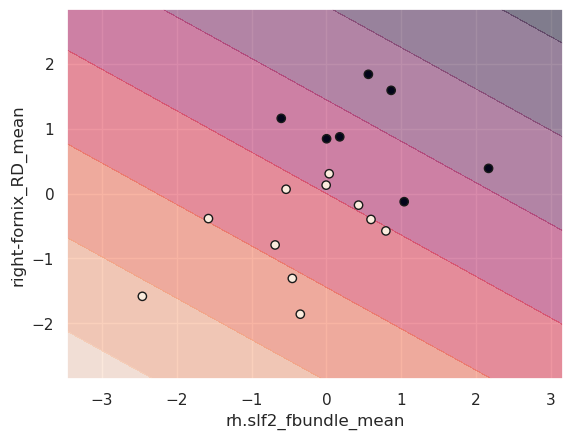

In [58]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']])

log_reg = LogisticRegression(
    penalty="l2",
    C=1e-6,
    dual=True,
    class_weight="balanced",
    random_state=7,
    solver="liblinear",
    max_iter=100000,
)

log_reg.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_scaled,
    response_method="predict_proba",
    xlabel='rh.slf2_fbundle_mean',
    ylabel='right-fornix_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

#### Feature Weights

In [7]:
import eli5
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

pipe = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss = 'log_loss',
                         n_jobs = -1, 
                         penalty = 'l2', 
                         alpha=100,
                         max_iter=10000
    )
)

pipe.fit(X_train, y_train)

eli5.show_weights(pipe, feature_names=X_train.columns)

Weight?,Feature
+0.002,acomm_icvf_mean
+0.001,epilepsy_duration
+0.000,acomm_fvf_tot_mean
-0.001,acomm_fbundle_mean
-0.002,epilepsy_type
-0.002,acomm_fextra_mean
-0.003,acomm_MD_mean
-0.003,cc.bodyt_frac_csf_mf_mean
-0.003,acomm_AD_mean
-0.004,right-fornix_RD_mean


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


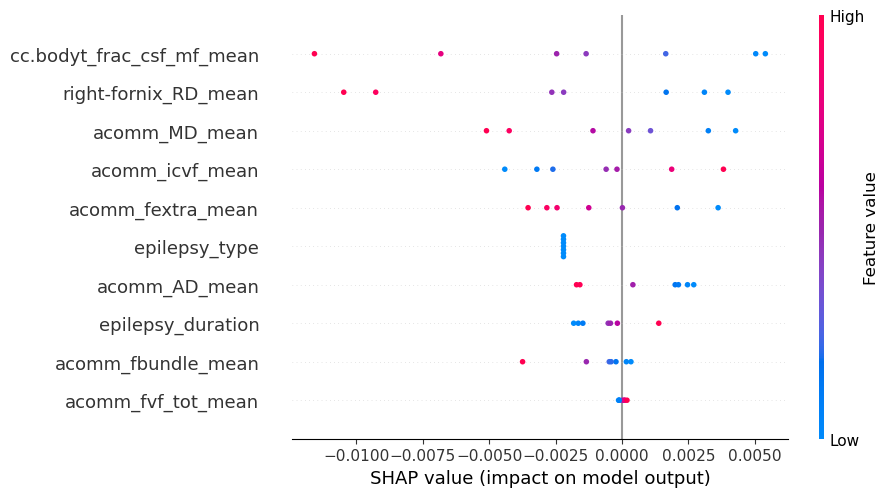

In [8]:
import shap
shap.initjs()
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logReg = SGDClassifier(
    loss = 'log_loss',
    n_jobs = -1, 
    penalty = 'l2', 
    alpha=50,
    max_iter=10000
)

logReg.fit(X_train, y_train)

explainer = shap.Explainer(logReg, X_train, feature_names=df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']].columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())

In [15]:
shap.plots.force(shap_values[0])

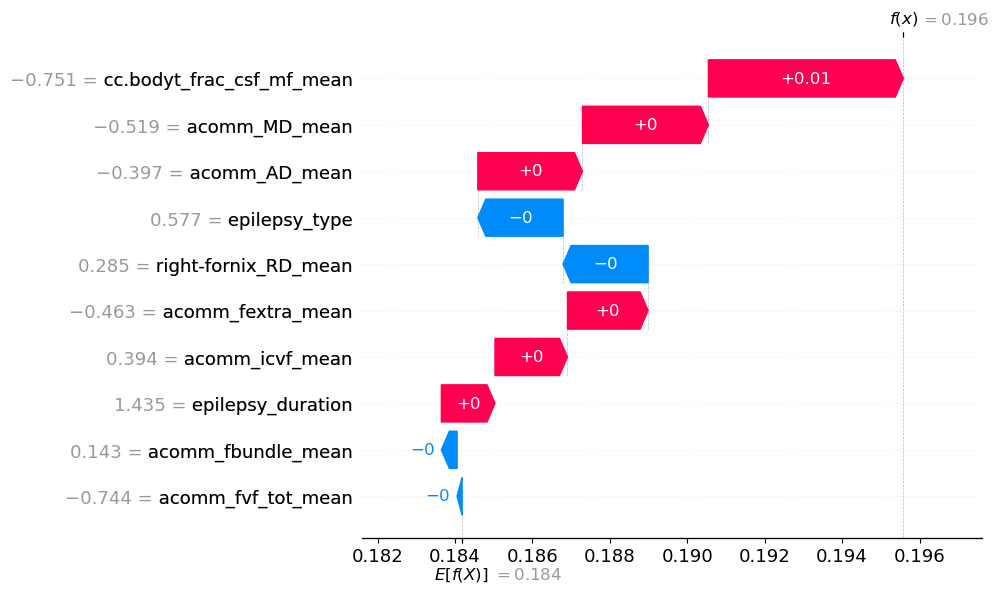

In [16]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


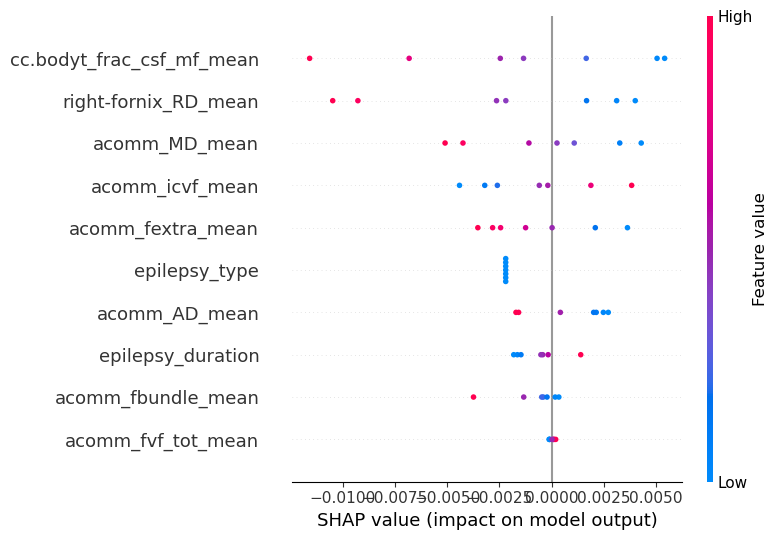

In [17]:
shap.summary_plot(shap_values, X_test)

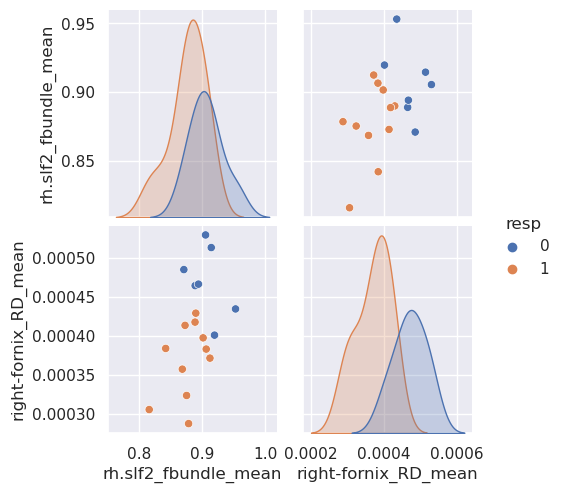

In [19]:
toPlot = ['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']
ax = sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

# SVM

#### Scaling pruning

In [5]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        penalty="l2"
        )

StandardScaler
F1: 0.730 | Pr: 0.808 | Re: 0.972 | AUC: 0.662 | Accuracy: 0.640 

MinMaxScaler
F1: 0.726 | Pr: 0.802 | Re: 0.972 | AUC: 0.652 | Accuracy: 0.633 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 

RobustScaler
F1: 0.711 | Pr: 0.792 | Re: 0.960 | AUC: 0.609 | Accuracy: 0.612 



the best scaler is the MinMaxScaler(), but the results are very similat to StandardScaler, therefore we will use standardScaler to maintain the same scaler.

#### Hyper parm pruning

In [17]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    "linearsvc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LinearSVC(
            penalty="l2",
            loss="hinge",
            dual=True,
            class_weight="balanced",
            random_state=7,
            max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  loss='hinge', max_iter=100000,
                                                  random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005,
                                          0.001, 0.0005, 0.0001, 5e-05, 1e-05,
                                          5e-06, 1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [18]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 score
[1.39244048 1.39244048 1.39244048 1.39244048 1.39244048 1.39244048
 1.41844048 1.52442262 1.58290476 1.58290476 1.58290476 1.58290476
 1.58290476]
[0.2420911  0.2420911  0.2420911  0.2420911  0.2420911  0.2420911
 0.24122682 0.26926774 0.27967532 0.27967532 0.27967532 0.27967532
 0.27967532]
[8 8 8 8 8 8 7 6 1 1 1 1 1]


In [21]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=1e-6,
        penalty="l2"
        )

StandardScaler
F1: 0.789 | Pr: 0.887 | Re: 0.991 | AUC: 0.794 | Accuracy: 0.729 

MinMaxScaler
F1: 0.784 | Pr: 0.879 | Re: 0.991 | AUC: 0.783 | Accuracy: 0.721 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_svm_cv(
        X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        C=1e-6,
        penalty="l2"
        )

l2
F1: 0.856 | Pr: 0.997 | Re: 1.000 | AUC: 0.998 | Accuracy: 0.831 



LinearSVC(C=1e-06, class_weight='balanced', loss='hinge', max_iter=100000,
          random_state=7)

#### Do again hyper parameter pruning with the selected features

In [61]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    "linearsvc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LinearSVC(
            penalty="l2",
            loss="hinge",
            dual=True,
            class_weight="balanced",
            random_state=7,
            max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']], y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  loss='hinge', max_iter=100000,
                                                  random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005,
                                          0.001, 0.0005, 0.0001, 5e-05, 1e-05,
                                          5e-06, 1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [62]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 score
[1.80619048 1.80354762 1.84572024 1.84541071 1.85328571 1.85328571
 1.85328571 1.85328571 1.85328571 1.85328571 1.85328571 1.85328571
 1.85328571]
[0.11831716 0.1310438  0.05449873 0.05128872 0.03185058 0.03185058
 0.03185058 0.03185058 0.03185058 0.03185058 0.03185058 0.03185058
 0.03185058]
[12 13 10 11  1  1  1  1  1  1  1  1  1]


#### Display decision boundary

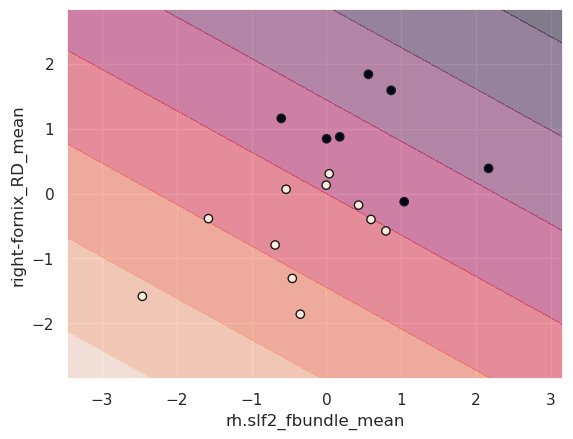

In [64]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']])

svm = LinearSVC(
    penalty="l2",
    loss="hinge",
    dual=True,
    C = 1e-6,
    class_weight="balanced",
    random_state=7,
    max_iter=100000,
)

svm.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    svm,
    X_scaled,
    response_method="decision_function",
    xlabel='rh.slf2_fbundle_mean',
    ylabel='right-fornix_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

# Gaussian Naive Bayes

In [4]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_gaussian_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.257 | Pr: 0.740 | Re: 0.991 | AUC: 0.590 | Accuracy: 0.414 

MinMaxScaler
F1: 0.260 | Pr: 0.740 | Re: 0.991 | AUC: 0.591 | Accuracy: 0.415 

Normalizer
F1: 0.579 | Pr: 0.717 | Re: 0.997 | AUC: 0.480 | Accuracy: 0.518 

Normalizer
F1: 0.593 | Pr: 0.702 | Re: 0.999 | AUC: 0.425 | Accuracy: 0.511 

RobustScaler
F1: 0.257 | Pr: 0.739 | Re: 0.991 | AUC: 0.588 | Accuracy: 0.414 

